In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.moment_helpers import cov2corr
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv("/content/drive/MyDrive/Genes/DataApp.csv", index_col = 0, header = 0)

In [28]:
y = data.Class
X = data.drop(columns = "Class")


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)


In [60]:
pd.DataFrame(y_train).to_csv("TrainClass.csv") # Training class needed to perform the knockoff procedure in R

# Apply PCA to reduce dimensions

In [40]:
pca = PCA()
principalComponents = pca.fit_transform(X_train)

In [41]:
train_pca = pd.DataFrame(data = principalComponents)
train_pca.to_csv('PCA_DataApp.csv')

In [42]:
selected_knock = [2, 4, 5, 6, 7, 243, 258, 399, 434, 437, 441] # Principal components selected by the knockoff procedure

In [43]:
X_train_knockoffpca = train_pca.iloc[:, selected_knock] # Keep only selected principal components

In [44]:
# Transform test data with the same transformation
test_pca = pca.transform(X_test)
X_test_knockoffpca = test_pca[:, selected_knock]

# Classification with Logistic Regression (after applying knockoffs)


In [45]:
# Logisitc Regression
class logreg_classifier:
    def __init__(self ):
        self.clf = None
        self.features = None
        self.test = None
        
    def fit(self, features, y_train, class_weight=None):
        self.features = features
        self.clf = LogisticRegression(class_weight=class_weight, random_state=1)
        
        # train the model
        self.clf.fit(self.features, y_train)
#         print(f"The best parameters are {self.clf.best_params_} with a score of {self.clf.best_score_} on validation data")
    
    def get_test_predict(self, text):
        self.test = text
        pred_val = self.predict(self.test)
        return pred_val
    
    def get_test_predict_proba(self, text):
        self.test = text
        pred_prob = self.clf.predict_proba(self.test)
        return pred_prob
        
    def get_metrics(self, y_test, pred_val):
        print("Report for test data \n\n", classification_report(y_test, pred_val))
        
    def predict(self, X):
        return self.clf.predict(X)

    def __call__(self, X):
        return self.predict(X)


In [46]:
lreg = logreg_classifier()
lreg.fit(X_train_knockoffpca, y_train)
pred_lreg = lreg.predict(X_test_knockoffpca) # Test set predictions
pred_train = lreg.predict(X_train_knockoffpca) # Traning set predictions

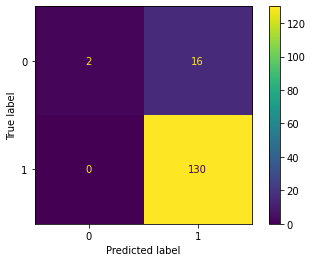

In [48]:
# Test set confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, pred_lreg)

In [ ]:
# Training set confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_train, pred_train)

In [ ]:
# Try Logistic Regression Classification with just PCA (no knockoff selection)
lreg_pca = logreg_classifier()
lreg_pca.fit(train_pca, y_train)
pred_lrpca = lreg_pca.predict(test_pca) 
pred_train_pca = lreg_pca.predict(train_pca)
# Test set confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(pred_lrpca, y_test) 

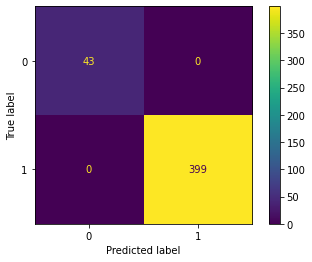

In [50]:
# Training set confusion matrix
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(pred_train_pca, y_train)